# 🧠 Media Bias Classifier

This project proposes a machine learning-based News Bias Detection System that analyses news articles to identify potential biases in reporting. By leveraging natural language processing (NLP) and explainable AI techniques, the system will assess textual content and detect linguistic patterns that indicate bias.

Bias in news media can shape public opinion and influence decision-making, making it essential to recognize and mitigate biased reporting. Traditional methods of bias detection rely on human judgment, which is subjective, time-consuming, and inconsistent. This project aims to build an automated and transparent system for detecting bias, promoting more critical and informed media consumption.

In [1]:
import nltk
import re
import string
import pandas as pd
import os
import shutil
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, BertTokenizer, TrainerCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from collections import Counter
import torch
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def remove_accents(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

def preprocess_for_bert(text):
    if not isinstance(text, str):
        return ""
    text = remove_accents(text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text.lower().strip()

def preprocess_for_bert_title(text):
    if not isinstance(text, str):
        return ""
    text = remove_accents(text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text.strip()

## BERT

**BERT-bidirectional encoder representations from transformers** is a deep learning model developed by Google for NLP. Unlike traditional models, BERT is bidirectional, meaning it can understand a word based on both its left and right context in a sentence—this gives it a much better grasp of meaning than models that only read text left-to-right (or right-to-left).

# 🔎 Analytic Approach

Detecting bias in articles might be an unclear objective, due to its abstraction. The first question to give attention to could be how exactly we detect bias, but there might be a better way to approach this. Instead, asking what bias is and how we should define it could provide more clarity.

**Multi-Class Classification** is presumably the better option. It eliminates the need for something to be classified as unbiased, as the left, center, and right all contain some form of bias.

In [3]:
# json_folder = r"C:\Fontys\Semester4\MediaBias_Predictor\Article-Bias-Prediction-main\data\jsons"

# data = []

# # Loop through JSON files
# for filename in os.listdir(json_folder):
#     if filename.endswith(".json"):
#         file_path = os.path.join(json_folder, filename)
#         with open(file_path, "r", encoding="utf-8") as f:
#             article = json.load(f)
            
#             # Extract only the fields present in the JSON
#             data.append({
#                 "ID": article.get("ID", ""),  
#                 "topic": article.get("topic", ""),  
#                 "source": article.get("source", ""),  
#                 "title": article.get("title", ""),  
#                 "date": article.get("date", ""),  
#                 "authors": article.get("authors", ""),  
#                 "content": article.get("content", ""),  
#                 "bias_text": article.get("bias_text", ""),  # Bias category (e.g., left, center, right)
#                 "url": article.get("url", ""),  
#                 "source_url": article.get("source_url", "")  
#             })

df = pd.read_csv('../news_bias_data.csv')


# df.to_csv("news_bias_data.csv", index=False)


In [4]:
df.head()

,ID,topic,source,title,date,authors,content,bias_text,url,source_url
0,004Gt3gcsotuiYmz,terrorism,New York Times - News,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...",left,http://www.nytimes.com/2016/09/20/nyregion/ahm...,www.nytimes.com
1,00eP4XD3VdMmHITE,supreme_court,Vox,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,left,https://www.vox.com/policy-and-politics/2018/9...,www.vox.com
2,00FTGIZEd6B8zQ4U,education,Ezra Klein,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,left,http://www.npr.org/blogs/thetwo-way/2014/05/06...,www.npr.org
3,00HGGqBRf1kzPRlg,us_house,Breitbart News,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...",right,http://www.breitbart.com/big-government/2017/0...,www.breitbart.com
4,00IzI5ynahBVtC9l,white_house,Guest Writer - Left,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,left,https://www.cnn.com/2019/07/11/politics/donald...,www.cnn.com


In [5]:
df["cleaned_title"] = df["title"].apply(preprocess_for_bert_title)
df["cleaned_content"] = df["content"].apply(preprocess_for_bert)

df[["title", "content", "cleaned_title", "cleaned_content"]].head()

,title,content,cleaned_title,cleaned_content
0,"Bomb Suspect Changed After Trip Abroad, Friend...","Besides his most recent trip to Quetta , Mr. R...","Bomb Suspect Changed After Trip Abroad, Friend...","besides his most recent trip to quetta , mr. r..."
1,Why Susan Collins claims she’s being bribed ov...,Is Maine Republican Sen. Susan Collins being b...,Why Susan Collins claims shes being bribed ove...,is maine republican sen. susan collins being b...
2,Poll: Prestigious Colleges Won't Make You Happ...,Poll : Prestigious Colleges Wo n't Make You Ha...,Poll: Prestigious Colleges Won't Make You Happ...,poll : prestigious colleges wo n't make you ha...
3,Paul Ryan Reportedly Says No Chance for Border...,"House Speaker Paul Ryan , at a private dinner ...",Paul Ryan Reportedly Says No Chance for Border...,"house speaker paul ryan , at a private dinner ..."
4,OPINION: Trump seeking change of legal fortune...,( CNN ) President Donald Trump has reason to h...,OPINION: Trump seeking change of legal fortune...,( cnn ) president donald trump has reason to h...


In [6]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create the TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords.words("english"))
tfidf_matrix = vectorizer.fit_transform(df["cleaned_content"])
feature_names = np.array(vectorizer.get_feature_names_out())

# Store class-wise indices
labels = df["bias_text"].unique()
label_indices = {label: df[df["bias_text"] == label].index for label in labels}

# Compute mean TF-IDF per word for each class
class_tfidf_means = {}
for label in labels:
    class_matrix = tfidf_matrix[label_indices[label]]
    class_tfidf_means[label] = class_matrix.mean(axis=0).A1

# Compute distinctive scores: class mean - average of other class means
class_keywords = {}
for label in labels:
    this_class = class_tfidf_means[label]
    other_means = np.mean([class_tfidf_means[l] for l in labels if l != label], axis=0)
    diff_score = this_class - other_means

    # Get top 10 most distinctive word indices
    top_indices = np.argsort(diff_score)[::-1][:10]
    class_keywords[label] = feature_names[top_indices]

# (Optional) Remove common words between classes
common_keywords = set()
for l1 in labels:
    for l2 in labels:
        if l1 != l2:
            common_keywords.update(set(class_keywords[l1]) & set(class_keywords[l2]))

for label in class_keywords:
    class_keywords[label] = [w for w in class_keywords[label] if w not in common_keywords]

for label in labels:
    this_class = class_tfidf_means[label]
    other_means = np.mean([class_tfidf_means[l] for l in labels if l != label], axis=0)
    diff_score = this_class - other_means
    sorted_indices = np.argsort(diff_score)[::-1]

    # Add more keywords until we have 10
    current_keywords = class_keywords[label]
    for idx in sorted_indices:
        candidate = feature_names[idx]
        if candidate not in common_keywords and candidate not in current_keywords:
            current_keywords.append(candidate)
        if len(current_keywords) == 10:
            break
    class_keywords[label] = current_keywords


# Print results
for label, keywords in class_keywords.items():
    print(f"\n🔹 Top distinctive keywords for '{label}':")
    print(", ".join(keywords))




🔹 Top distinctive keywords for 'left':
replay, cnn, watched, videos, romney, watch, clinton, like, campaign, must

🔹 Top distinctive keywords for 'right':
mr, percent, illegal, fbi, obamacare, mrs, fox, media, america, president

🔹 Top distinctive keywords for 'center':
says, trump, impeachment, said, trial, us, 2020, coronavirus, ukraine, china


In [7]:
features = ["title", "content", "bias_text"]

"""left_df = df[df["bias_text"] == "left"]
center_df = df[df["bias_text"] == "center"]
right_df = df[df["bias_text"] == "right"]

total_samples = 8000
samples_per_class = total_samples // 3

# Randomly sample from each class
left_sampled = left_df.sample(n=samples_per_class, random_state=42)
center_sampled = center_df.sample(n=samples_per_class, random_state=42)
right_sampled = right_df.sample(n=samples_per_class, random_state=42)

df = pd.concat([left_sampled, center_sampled, right_sampled])

# Shuffle the final dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)"""

df[features].head()


,title,content,bias_text
0,"Bomb Suspect Changed After Trip Abroad, Friend...","Besides his most recent trip to Quetta , Mr. R...",left
1,Why Susan Collins claims she’s being bribed ov...,Is Maine Republican Sen. Susan Collins being b...,left
2,Poll: Prestigious Colleges Won't Make You Happ...,Poll : Prestigious Colleges Wo n't Make You Ha...,left
3,Paul Ryan Reportedly Says No Chance for Border...,"House Speaker Paul Ryan , at a private dinner ...",right
4,OPINION: Trump seeking change of legal fortune...,( CNN ) President Donald Trump has reason to h...,left


In [8]:
# Check for missing values
print(df.isnull().sum())

# Check the distribution of bias_text labels
print(df['bias_text'].value_counts())

print("\nDataset after removing missing values:")
print(df.shape)

ID                    0
topic                 0
source                0
title                 0
date               4407
authors            9668
content               0
bias_text             0
url                   0
source_url            0
cleaned_title         0
cleaned_content       0
dtype: int64
bias_text
right     13734
left      13005
center    10815
Name: count, dtype: int64

Dataset after removing missing values:
(37554, 12)


The **BERT** model requires much less data preprocessing, since it is pre-trained on **raw text**. It is in fact helpful to include the things that we otherwise exclude from other models, because it provides a certain context that BERT recognizes.

In [9]:
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["bias_text"]) # Representing left, center, right as 0, 1, 2

In [10]:
# Define a function to count keyword occurrences
def count_keywords(text, keywords):
    return sum(1 for keyword in keywords if keyword in text)

# Add keyword counts for each class
df["left_keyword_count"] = df["cleaned_content"].apply(lambda x: count_keywords(x, class_keywords["left"]))
df["center_keyword_count"] = df["cleaned_content"].apply(lambda x: count_keywords(x, class_keywords["center"]))
df["right_keyword_count"] = df["cleaned_content"].apply(lambda x: count_keywords(x, class_keywords["right"]))

In [11]:
train_titles, val_titles, train_contents, val_contents, train_labels, val_labels = train_test_split(
    df["title"].tolist(),
    df["content"].tolist(),
    df["label_id"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"]
)

### Tokenization

Before text can go into BERT, it has to be converted into numbers (tokens).

- It Splits text into subwords (e.g., "unbelievable" → "un", "##believable").

- Maps words/subwords to token IDs that BERT understands.

- Pads or truncates text to a fixed length (so batches are consistent).

- Returns attention masks (to tell the model which tokens are real vs. padding).

Two example sentences:

- *L, did you know* (5 tokens)
- *Gods of death love apples!* (6 tokens)

If we set the max_length to be 8, it will allow a maximum of 8 tokens. If a piece of text has more than that, it truncates it down to 8, and if it has less, it adds padding to get it to 8. In the example sentences, it would be represented as follows:

- *L, did you know [PAD] [PAD] [PAD]* (8 tokens)
- *Gods of death love apples! [PAD] [PAD]* (8 tokens)

The **attention mask** is like a signal for the model to know which tokens are real words and which ones are padding (which should be ignored). Padding is displayed as 0 and real words as 1.

The attention mask for *L, did you know [PAD] [PAD] [PAD]* would look like *[1, 1, 1, 1, 1, 0, 0, 0]*.

#### Why is this important?

Deep learning models like BERT process data in batches. Having all sentences the same length allows the model to process them simultaneously. If sentences have different lengths, the model would need to deal with each sentence one by one. Computers use matrices to process data efficiently. If sentences have different lengths, you can't create a matrix because the rows (sentences) won't have the same number of columns (tokens).

- __init__:
- - Stores the tokenized input (encodings) and the labels.

- __len__:
- - Returns the total number of samples in the dataset. Required so the model knows how many items to expect.

- __getitem__:
- - When the model asks for a specific item (e.g., the 5th article), this method: Converts the data into PyTorch tensors and returns a dictionary with the correct format: input_ids, attention_mask, and labels

#### Tensors

Tensors can be seen as multi-dimensional arrays:

- Scalar (0D) -> 3,14 -> torch.tensor(3.14)
- Vector (1D) -> [1, 2, 3] -> torch.tensor([1, 2, 3])
- Matrix (2D) -> [[1, 2], [3, 4]] -> torch.tensor([[1, 2], [3, 4]])
- Tensor (3D+) -> [[[...], [...]], [[...], [...]]] -> Used in images, NLP, etc.

In NLP with BERT:

A sentence becomes a 1D tensor (list of token IDs)

A batch of sentences becomes a 2D tensor (each row is a sentence)

In [12]:
print(torch.cuda.is_available())        # Should be True
print(torch.cuda.device_count())        # Should be >= 1
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 4060


In [ ]:
import torch.nn as nn
from transformers import BertModel
from sklearn.metrics import classification_report  # Import classification_report

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", num_labels=3)

# Compute accuracy function
def compute_accuracy(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)  # get the index of the max probability for each prediction
    return {"eval_accuracy": accuracy_score(labels, preds)}

# Dataset definition
class NewsDatasetWithKeywords(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, additional_features):
        self.encodings = encodings
        self.labels = labels
        self.additional_features = additional_features

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["additional_features"] = torch.tensor(self.additional_features[idx])
        return item

    def __len__(self):
        return len(self.labels)

titles = df["cleaned_title"].tolist()
content = df["cleaned_content"].tolist()
labels = df["label_id"].tolist()

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

for fold, (train_index, val_index) in enumerate(kfold.split(titles, labels)):
    print(f"\n===== Fold {fold + 1} =====")

    train_titles = [titles[i] for i in train_index]
    val_titles = [titles[i] for i in val_index]
    train_contents = [content[i] for i in train_index]
    val_contents = [content[i] for i in val_index]

    train_labels = [labels[i] for i in train_index]
    val_labels = [labels[i] for i in val_index]

    print(f"Training label distribution: {Counter(train_labels)}")
    print(f"Validation label distribution: {Counter(val_labels)}")

    additional_features = df[["left_keyword_count", "center_keyword_count", "right_keyword_count"]].values

    train_encodings = tokenizer(train_titles, train_contents, truncation='only_second', padding=True, max_length=512)
    val_encodings = tokenizer(val_titles, val_contents, truncation='only_second', padding=True, max_length=512)

    train_features = {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "additional_features": torch.tensor(additional_features[train_index])  # Add keyword counts
    }

    val_features = {
        "input_ids": val_encodings["input_ids"],
        "attention_mask": val_encodings["attention_mask"],
        "additional_features": torch.tensor(additional_features[val_index])  # Add keyword counts
    }

    train_dataset = NewsDatasetWithKeywords(train_encodings, train_labels, additional_features[train_index])
    val_dataset = NewsDatasetWithKeywords(val_encodings, val_labels, additional_features[val_index])

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    class CustomEarlyStoppingCallback(EarlyStoppingCallback):
        def __init__(self):
            super().__init__()
            self.early_stopping_patience = 2

    training_args = TrainingArguments(
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=100,
        weight_decay=0.05,
        logging_steps=200,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        save_total_limit=1,
        fp16=True,
        report_to="none",
        learning_rate=3e-5,
        lr_scheduler_type='cosine'
    )

    class BertWithKeywords(nn.Module):
        def __init__(self, num_labels):
            super(BertWithKeywords, self).__init__()
            self.bert = BertModel.from_pretrained("bert-base-uncased")
            self.dropout = nn.Dropout(0.1)
            self.classifier = nn.Linear(self.bert.config.hidden_size + 3, num_labels)  # Add 3 for keyword features

        def forward(self, input_ids, attention_mask, additional_features, labels=None):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            combined_output = torch.cat((pooled_output, additional_features), dim=1)  # Concatenate features
            combined_output = self.dropout(combined_output)
            logits = self.classifier(combined_output)
            
            # Compute loss if labels are provided
            loss = None
            if labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits, labels)
            
            return {"loss": loss, "logits": logits}
    
    trainer = Trainer(
        model=BertWithKeywords(num_labels=3),  # Initialize the custom model directly
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_accuracy,
        callbacks=[CustomEarlyStoppingCallback()] # Stops the training when it stops learning (overfitting)
    )

    trainer.train()

    eval_result = trainer.evaluate()
    trainer.save_model(f"saved_models/fold_{fold}")
    print(f"Fold {fold + 1} Accuracy: {eval_result['eval_accuracy']:.4f}")
    accuracies.append(eval_result['eval_accuracy'])

print("\n===== Cross-Validation Complete =====")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")

predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

print(classification_report(val_labels, predictions))
print("Accuracy:", accuracy_score(val_labels, preds))


===== Fold 1 =====
Training label distribution: Counter({2: 9174, 1: 8606, 0: 7256})
Validation label distribution: Counter({2: 4560, 1: 4399, 0: 3559})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.558900,0.497480,0.810273
2,0.373400,0.490515,0.834079
3,0.253900,0.711266,0.831682


Fold 1 Accuracy: 0.8341

===== Fold 2 =====
Training label distribution: Counter({2: 9141, 1: 8694, 0: 7201})
Validation label distribution: Counter({2: 4593, 1: 4311, 0: 3614})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.577100,0.503374,0.799409
2,0.377300,0.489441,0.823614
3,0.232300,0.681384,0.829845


Fold 2 Accuracy: 0.8298

===== Fold 3 =====
Training label distribution: Counter({2: 9153, 1: 8710, 0: 7173})
Validation label distribution: Counter({2: 4581, 1: 4295, 0: 3642})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.554200,0.504466,0.805560
2,0.387900,0.521943,0.828487
3,0.221100,0.686684,0.830244


Fold 3 Accuracy: 0.8302

===== Cross-Validation Complete =====
Mean Accuracy: 0.8314


NameError: name 'classification_report' is not defined

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(val_labels, pred_labels))
print("Accuracy:", accuracy_score(val_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3642
           1       0.82      0.85      0.83      4295
           2       0.85      0.81      0.83      4581

    accuracy                           0.83     12518
   macro avg       0.83      0.83      0.83     12518
weighted avg       0.83      0.83      0.83     12518

Accuracy: 0.8302444479948874


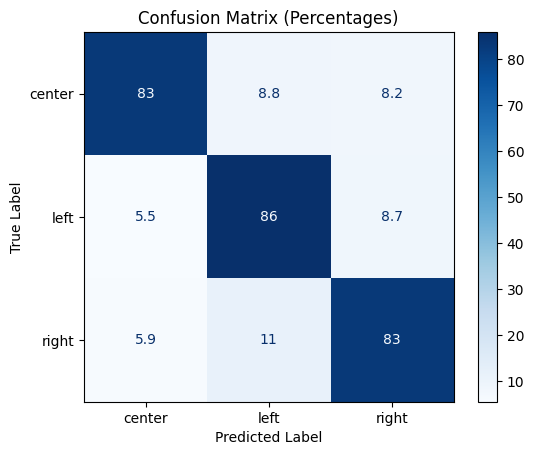

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(val_labels, pred_labels)

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display the confusion matrix with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Percentages)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()